In [1]:
import os
os.chdir('/Users/tjams20/Documents/repos/CCS/examples/Advanced_Tutorials/MD_tutorial/CCS')

from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS",DFT_DB="DFT.db",include_forces=False)

    Fetching data: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 699/699 [00:07<00:00, 95.52it/s]


In [2]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True",
    },
    "Twobody": {
                "Xx-Xx": {
                        "Rcut": 5.5,
                        "Resolution": 0.25,
                        "Swtype": "sw",
                        "const_type" : "Mono"   
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [3]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Cl', 'Na']
    Generating two-body potentials from one-body information.
    Adding pair: Cl-Cl
    Adding pair: Cl-Na
    Adding pair: Na-Na
    Applying monotonic constraints for pair:  Cl-Cl
    Applying monotonic constraints for pair:  Cl-Na
    Applying monotonic constraints for pair:  Na-Na
    There is linear dependence in stochiometry matrix!
    Removing onebody term: Na


    Finding optimum switch: 100%|█████████████████████████████████████████████████████████████████████████████| 3360/3360 [00:07<00:00, 437.09it/s]


    The best switch is (13, 7, 14) with rmse: 0.21974758246679302, corresponding to distances of [5.72 3.69 5.73] Å for element pairs ['Cl-Cl', 'Cl-Na', 'Na-Na'].


In [4]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True",
    },
    "Twobody": {
                "Xx-Xx": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "rep",
                        "const_type" : "Mono"   
                },
                "Cl-Na": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type": "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [5]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Cl', 'Na']
    Generating two-body potentials from one-body information.
    Adding pair: Cl-Cl
    Adding pair: Na-Na
    Applying monotonic constraints for pair:  Cl-Na
    Applying monotonic constraints for pair:  Cl-Cl
    Applying monotonic constraints for pair:  Na-Na
    Merging intervals for pair Cl-Cl; number of intervals reduced from 70 to 68. 
    Merging intervals for pair Na-Na; number of intervals reduced from 75 to 74. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: Na


    Finding optimum switch: 100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:06<00:00, 28.79it/s]

    The best switch is (99, 68, 74) with rmse: 0.21102132593650338, corresponding to distances of [4.03 5.97 6.03] Å for element pairs ['Cl-Na', 'Cl-Cl', 'Na-Na'].


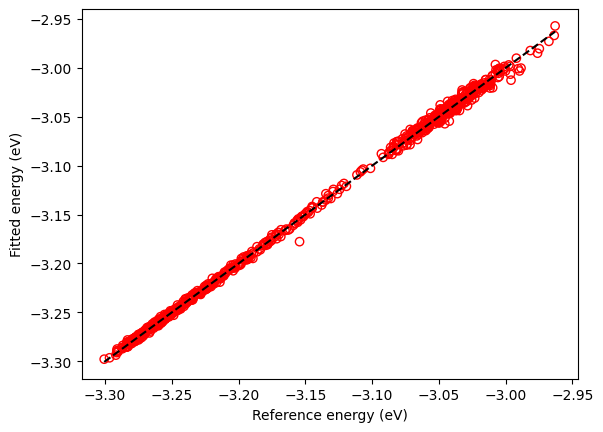

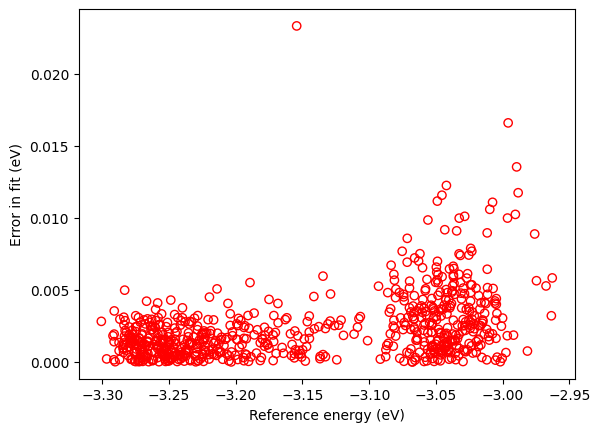

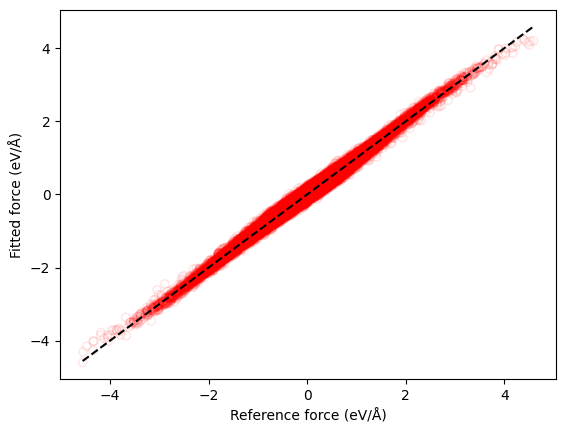

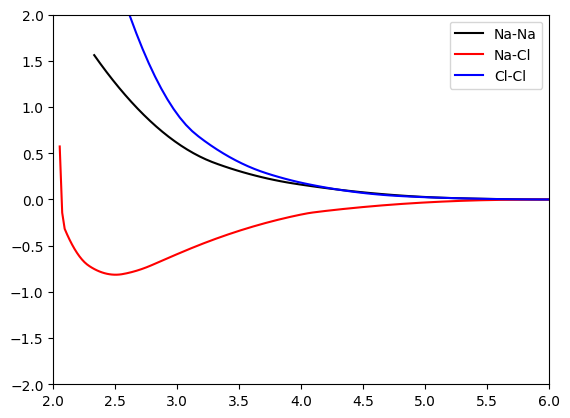

In [6]:
import numpy as np
import json
import matplotlib.pyplot as plt

with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

with open("structures.json", "r") as f:
    training_set = json.load(f)


err=np.loadtxt("CCS_error.out")

err[:,0]=err[:,0]/err[:,3]
err[:,1]=err[:,1]/err[:,3]
err[:,2]=err[:,2]/err[:,3]

plt.xlabel('Reference energy (eV)')
plt.ylabel('Fitted energy (eV)')
plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
plt.show()
plt.xlabel('Reference energy (eV)')
plt.ylabel('Error in fit (eV)')
plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
plt.show()


err_F=np.loadtxt("CCS_error_forces.out")
plt.xlabel('Reference force (eV/Å)')
plt.ylabel('Fitted force (eV/Å)')
plt.plot( [min(err_F[:,0]),max(err_F[:,0])],[min(err_F[:,0]),max(err_F[:,0])],'--',color='black')
plt.scatter(err_F[:,0],err_F[:,1],facecolors='none', edgecolors='red',alpha=0.1 )
plt.show()




plt.xlim(2,6)
plt.ylim(-2.0,2.0)
# plt.xlabel('Distance (Å)')
# plt.ylabel('Potential (eV)')
r=np.array(CCS_params["Two_body"]["Na-Na"]["r"])
NaNa=np.array(CCS_params["Two_body"]["Na-Na"]["spl_a"])
plt.plot(r,NaNa,color='black',label="Na-Na")
r=np.array(CCS_params["Two_body"]["Cl-Na"]["r"])
NaCl=np.array(CCS_params["Two_body"]["Cl-Na"]["spl_a"])
plt.plot(r,NaCl,color='red',label="Na-Cl")
r=np.array(CCS_params["Two_body"]["Cl-Cl"]["r"])
ClCl=np.array(CCS_params["Two_body"]["Cl-Cl"]["spl_a"])
plt.plot(r,ClCl,color='blue',label="Cl-Cl")

plt.legend()
plt.show()

In [7]:
from ase.lattice.cubic import FaceCenteredCubic
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase import units
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
from ase.io.trajectory import Trajectory
from ase.build import bulk
import json


json_file = open("CCS_params.json")
CCS_params = json.load(json_file)



atoms=bulk('NaCl','rocksalt',a=6.369976562933614,cubic=True)
atoms=atoms*[2,2,2]
charge_dict={"Na":1,"Cl":-1}

calc = CCS(CCS_params=CCS_params)
atoms.calc=calc

print("Initial energy:", atoms.get_potential_energy())

T=1174

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=T)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = Langevin(atoms, 2 * units.fs, T * units.kB, 0.1)


def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))

#Equillibrate
printenergy(atoms)
for i in range(10):
    dyn.run(100)
    printenergy(atoms)

traj = Trajectory('moldyn.traj', 'w', atoms)
dyn.attach(traj.write, interval=100)


# Now run the dynamics
printenergy(atoms)
for i in range(200):
    print("STEP: ", i*100," ",end='')
    dyn.run(100)
    printenergy(atoms)

print("Final energy:", atoms.get_potential_energy())


/Users/tjams20/opt/anaconda3/envs/CCS_fit/lib/python3.9/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)
/Users/tjams20/opt/anaconda3/envs/CCS_fit/lib/python3.9/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


Initial energy: -207.14177123130847
Energy per atom: Epot = -3.237eV  Ekin = 0.135eV (T=1044K)  Etot = -3.102eV
Energy per atom: Epot = -3.148eV  Ekin = 0.136eV (T=1054K)  Etot = -3.011eV
Energy per atom: Epot = -3.126eV  Ekin = 0.141eV (T=1087K)  Etot = -2.985eV
Energy per atom: Epot = -3.094eV  Ekin = 0.146eV (T=1130K)  Etot = -2.948eV
Energy per atom: Epot = -3.125eV  Ekin = 0.170eV (T=1318K)  Etot = -2.955eV
Energy per atom: Epot = -3.107eV  Ekin = 0.141eV (T=1094K)  Etot = -2.966eV
Energy per atom: Epot = -3.122eV  Ekin = 0.146eV (T=1129K)  Etot = -2.977eV
Energy per atom: Epot = -3.153eV  Ekin = 0.175eV (T=1351K)  Etot = -2.978eV
Energy per atom: Epot = -3.143eV  Ekin = 0.125eV (T=964K)  Etot = -3.018eV
Energy per atom: Epot = -3.122eV  Ekin = 0.165eV (T=1277K)  Etot = -2.957eV
Energy per atom: Epot = -3.124eV  Ekin = 0.189eV (T=1462K)  Etot = -2.935eV
Energy per atom: Epot = -3.124eV  Ekin = 0.189eV (T=1462K)  Etot = -2.935eV
STEP:  0  Energy per atom: Epot = -3.123eV  Ekin = 0.

In [8]:
# run some more

for i in range(200):
    print("STEP: ", i*100," ",end='')
    dyn.run(100)
    printenergy(atoms)

STEP:  0  Energy per atom: Epot = -3.074eV  Ekin = 0.181eV (T=1399K)  Etot = -2.893eV
STEP:  100  Energy per atom: Epot = -3.086eV  Ekin = 0.159eV (T=1228K)  Etot = -2.927eV
STEP:  200  Energy per atom: Epot = -3.102eV  Ekin = 0.153eV (T=1181K)  Etot = -2.950eV
STEP:  300  Energy per atom: Epot = -3.116eV  Ekin = 0.124eV (T=959K)  Etot = -2.992eV
STEP:  400  Energy per atom: Epot = -3.096eV  Ekin = 0.122eV (T=948K)  Etot = -2.974eV
STEP:  500  Energy per atom: Epot = -3.073eV  Ekin = 0.142eV (T=1098K)  Etot = -2.931eV
STEP:  600  Energy per atom: Epot = -3.119eV  Ekin = 0.160eV (T=1235K)  Etot = -2.959eV
STEP:  700  Energy per atom: Epot = -3.093eV  Ekin = 0.144eV (T=1111K)  Etot = -2.950eV
STEP:  800  Energy per atom: Epot = -3.086eV  Ekin = 0.132eV (T=1024K)  Etot = -2.954eV
STEP:  900  Energy per atom: Epot = -3.084eV  Ekin = 0.165eV (T=1274K)  Etot = -2.919eV
STEP:  1000  Energy per atom: Epot = -3.078eV  Ekin = 0.147eV (T=1136K)  Etot = -2.931eV
STEP:  1100  Energy per atom: Epot 

Na Diffusion constant: 5.0457593364851457e-05  cm^2/s, Standard deviation 9.982274239585402e-06
Cl Diffusion constant: 4.71127283869068e-05  cm^2/s, Standard deviation 1.5820153268124742e-06
REFERENCE VALUES FROM GAP POTENTIALS https://pubs.acs.org/doi/full/10.1021/acs.jpcc.0c08870
Na Diffusion constant:  9.78E-5 cm^2/s, Standard deviation: 0.19E-5 
Cl Diffusion constant:  7.73E-5 cm^2/s, Standard deviation: 0.11E-5 


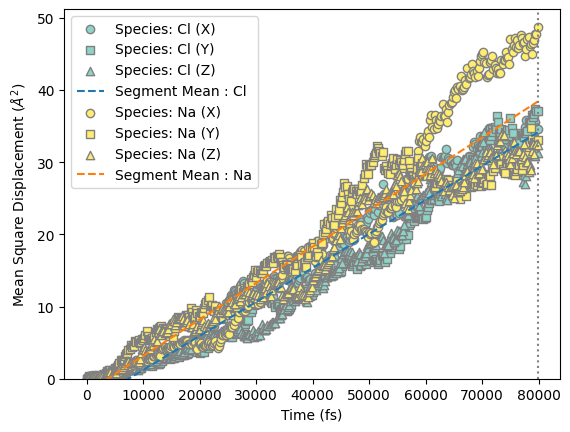

In [9]:
from ase.md.analysis import DiffusionCoefficient
from ase.io.trajectory import Trajectory
traj = Trajectory('moldyn.traj')
Df=DiffusionCoefficient(traj, 200*units.fs, atom_indices=None, molecule=False)
Df.calculate()
D=Df.get_diffusion_coefficients()
conv_factor=units.fs*0.1

print("Na Diffusion constant:", D[0][1]*conv_factor," cm^2/s, Standard deviation",D[1][1]*conv_factor)
print("Cl Diffusion constant:", D[0][0]*conv_factor," cm^2/s, Standard deviation",D[1][0]*conv_factor)


print("REFERENCE VALUES FROM GAP POTENTIALS https://pubs.acs.org/doi/full/10.1021/acs.jpcc.0c08870")

print("Na Diffusion constant:  9.78E-5 cm^2/s, Standard deviation: 0.19E-5 ")
print("Cl Diffusion constant:  7.73E-5 cm^2/s, Standard deviation: 0.11E-5 ")
Df.plot()

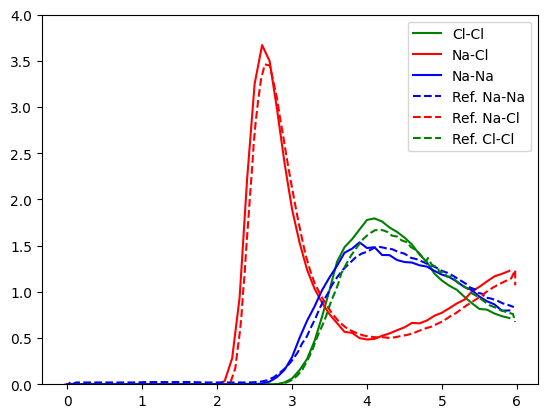

In [11]:
#Radial distribution function

import numpy as np
import itertools as iter
traj = Trajectory('moldyn.traj')

N_bins=60

h_NaNa=np.zeros((N_bins,))
h_NaCl=np.zeros((N_bins,))
h_ClCl=np.zeros((N_bins,))
counter=0
N=len(atoms)

d_NaNa=[]
d_NaCl=[]
d_ClCl=[]

mask_Na=atoms.symbols=='Na'
mask_Cl=atoms.symbols=='Cl'

for a in traj:
    counter += 1
    a.wrap()
    d_all = np.array(a.get_all_distances(mic=True)) # NxN matrix with all pair-distances
    d_NaNa.extend( d_all[mask_Na,:] [:,mask_Na].flatten()) #Extract Na-Na distances
    d_NaCl.extend( d_all[mask_Na,:] [:,mask_Cl].flatten()) #Extract Na-Cl distances
    d_ClCl.extend( d_all[mask_Cl,:] [:,mask_Cl].flatten()) #Extract Cl-Cl distances
           

hh,r=np.histogram(d_NaNa,range=(0,6),bins=60)
vol=(4/3.)*np.pi*r**3
nrm=np.diff(vol)
h_NaNa = 4*hh/nrm/N/counter
h_NaNa[0]=0

hh,r=np.histogram(d_NaCl,range=(0,6),bins=60)
vol=(4/3.)*np.pi*r**3
nrm=np.diff(vol)
h_NaCl = 4*hh/nrm/N/counter
h_NaCl[0]=0

hh,r=np.histogram(d_ClCl,range=(0,6),bins=60)
vol=(4/3.)*np.pi*r**3
nrm=np.diff(vol)
h_ClCl = 4*hh/nrm/N/counter
h_ClCl[0]=0


import matplotlib.pyplot as plt
Dens=len(atoms)/atoms.get_volume()

plt.ylim(0,4)
plt.plot(r[0:-1],h_ClCl/Dens,label="Cl-Cl",color="green")
plt.plot(r[0:-1],h_NaCl/Dens,label="Na-Cl",color="red")
plt.plot(r[0:-1],h_NaNa/Dens,label="Na-Na",color="blue")


ref_NaNa=np.loadtxt('../RefData/NaNa.txt')
ref_NaCl=np.loadtxt('../RefData/NaCl.txt')
ref_ClCl=np.loadtxt('../RefData/ClCl.txt')

plt.plot(ref_NaNa[:,0],ref_NaNa[:,1,],'--',label="Ref. Na-Na",color="blue")
plt.plot(ref_NaCl[:,0],ref_NaCl[:,1,],'--',label="Ref. Na-Cl",color="red")
plt.plot(ref_ClCl[:,0],ref_ClCl[:,1,],'--',label="Ref. Cl-Cl",color="green")


plt.legend()

In [12]:
!ase -T gui moldyn.traj

Traceback (most recent call last):
  File "/usr/local/bin/ase", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/site-packages/ase/cli/main.py", line 103, in main
    f(args)
  File "/usr/local/lib/python3.10/site-packages/ase/gui/ag.py", line 98, in run
    from ase.gui.gui import GUI
  File "/usr/local/lib/python3.10/site-packages/ase/gui/gui.py", line 12, in <module>
    import ase.gui.ui as ui
  File "/usr/local/lib/python3.10/site-packages/ase/gui/ui.py", line 8, in <module>
    import tkinter as tk
  File "/usr/local/Cellar/python@3.10/3.10.8/Frameworks/Python.framework/Versions/3.10/lib/python3.10/tkinter/__init__.py", line 37, in <module>
    import _tkinter # If this fails your Python may not be configured for Tk
ModuleNotFoundError: No module named '_tkinter'


Buckingham fit (not optimised) for element pair Cl-Na;     V(r) = -66.26*exp(-1.41*r) -(-272.38)/r^6.
Lennard Jones fit (not optimised) for element pair Cl-Na;  V(r) = 4*0.99*((2.09/r)^12 - (2.09/r)^6)
Morse fit (not optimised) for element pair Cl-Na;          V(r) = 0.83*((1-np.exp(-1.51*(r-2.50)))^2 - 1)
Pedone fit (not optimised) for element pair Cl-Na;         V(r) = 0.94*((1-np.exp(-1.41*(r-2.33)))^2 - 1) + 4186.68/r^12


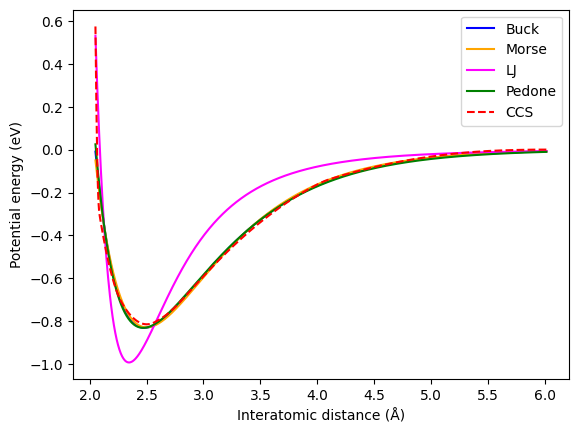

/Users/tjams20/opt/anaconda3/envs/CCS_fit/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Buckingham fit (not optimised) for element pair Cl-Cl;     V(r) = 11.43*exp(-18.26*r) -(-661.45)/r^6.
Lennard Jones fit (not optimised) for element pair Cl-Cl;  V(r) = 4*-4.76*((1.83/r)^12 - (1.83/r)^6)
Morse fit (not optimised) for element pair Cl-Cl;          V(r) = -21960.20*((1-np.exp(-1.83*(r--2.87)))^2 - 1)
Pedone fit (not optimised) for element pair Cl-Cl;         V(r) = -14759.74*((1-np.exp(-1.64*(r--3.36)))^2 - 1) + 36796.44/r^12


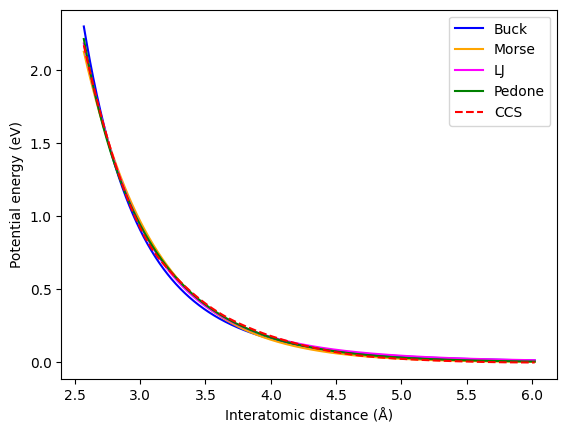

Buckingham fit (not optimised) for element pair Na-Na;     V(r) = 20.62*exp(-14.79*r) -(-321.15)/r^6.
Lennard Jones fit (not optimised) for element pair Na-Na;  V(r) = 4*-1.43*((2.10/r)^12 - (2.10/r)^6)
Morse fit (not optimised) for element pair Na-Na;          V(r) = -8.45*((1-np.exp(-1.44*(r-0.72)))^2 - 1)
Pedone fit (not optimised) for element pair Na-Na;         V(r) = -4280.24*((1-np.exp(-1.44*(r--3.64)))^2 - 1) + -1459.94/r^12


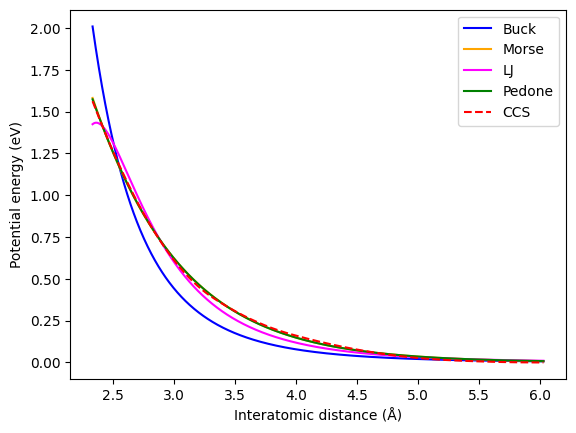

In [13]:
from ccs_fit.scripts.ccs_export_FF import write_FF
write_FF("CCS_params.json")